In [6]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [7]:
df = pd.read_csv("All Earthquakes.csv")
df.head(5)

,No.,Orgin date,Longitude(E),Latitude(N),Magnitude,Depth,Location,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,Small area,2025-02-12 0:09,121.942,24.3840,3.8,24.3,24.38N 121.94E,i.e. 42.5 km SSE of Yilan County(24.38N 121.94E,i.e. 42.5 km SSE of Yilan County),NaN,NaN
1,64,2025-02-11 22:04,121.665,24.1742,4.0,13.3,24.17N 121.66E,i.e. 20.8 km NNE of Hualien County(24.17N 121...,i.e. 20.8 km NNE of Hualien County),NaN,NaN
2,Small area,2025-02-11 20:46,120.459,23.5483,3.2,5.6,23.55N 120.46E,i.e. 19.6 km ENE of Chiayi County(23.55N 120.46E,i.e. 19.6 km ENE of Chiayi County),NaN,NaN
3,63,2025-02-11 15:52,120.496,23.2458,4.1,7.7,23.25N 120.50E,i.e. 42.5 km NE of Tainan City(23.25N 120.50E,i.e. 42.5 km NE of Tainan City),NaN,NaN
4,Small area,2025-02-11 15:45,120.505,23.2862,3.6,7.5,23.29N 120.50E,i.e. 46.2 km NE of Tainan City(23.29N 120.50E,i.e. 46.2 km NE of Tainan City),NaN,NaN


In [8]:
# Convert date to datetime and extract features
df['datetime'] = pd.to_datetime(df['Orgin date'])
df['timestamp'] = df['datetime'].astype(np.int64) // 10**9  # Unix timestamp
df['days_since_first'] = (df['datetime'] - df['datetime'].min()).dt.total_seconds() / 86400

In [9]:
# Select features and target
features = ['Longitude(E)', 'Latitude(N)', 'days_since_first']
targets = ['Magnitude', 'Depth']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(df[features])
y = df[targets].values

# Combine features and targets for HMM
data = np.column_stack((X, y))

# Gaussian HMM class fitting (inspired by online article / code)

In [42]:
class EarthquakePredictor:
    def __init__(self, n_components=3):
        self.n_components = n_components
        self.model = hmm.GaussianHMM(
            n_components=n_components,
            covariance_type="diag",
            # inspired from example I saw online
            n_iter=1000,
            random_state=42
        )
        self.scaler = StandardScaler()
        
    def fit(self, X, y):
        """Fit the HMM model"""
        # Standardize features
        X_scaled = self.scaler.fit_transform(X)
        # Combine features and targets
        data = np.column_stack((X_scaled, y))
        self.model.fit(data)
        return self
        
    def predict(self, X):
        """Predict magnitude and depth for given features"""
        X_scaled = self.scaler.transform(X)
        # Predict the most likely state sequence
        states = self.model.predict(np.column_stack((X_scaled, np.zeros((len(X_scaled), 2)))))
        # Get the mean values for each state
        preds = np.array([self.model.means_[state][3:5] for state in states])
        return preds, states
    
    def forecast_next(self, n_steps=1):
        """Forecast future earthquakes"""
        # Get current state
        current_state = self.model.predict(data[-1:])[0]
        
        # Generate samples from current state
        samples, states = self.model.sample(n_steps, current_state)
        
        # Inverse transform the features
        features_scaled = samples[:, :3]
        features = self.scaler.inverse_transform(features_scaled)
        
        # Extract predictions
        preds = samples[:, 3:5]
        
        # Create datetime from days_since_first
        last_date = df['datetime'].max()
        dates = [last_date + pd.Timedelta(days=float(days)) 
                for days in (features[:, 2] - features[0, 2])]
        
        results = pd.DataFrame({
            'date': dates,
            'longitude': features[:, 0],
            'latitude': features[:, 1],
            'pred_magnitude': preds[:, 0],
            'pred_depth': preds[:, 1],
            'state': states
        })
        
        return results

    def get_transmat(self):
        return self.model.transmat_ 

# Model training & evaluation

In [43]:
# Initialize and train the model
predictor = EarthquakePredictor(n_components=3)
predictor.fit(df[features], df[targets])

# Predict on training data
preds, states = predictor.predict(df[features])

# Add predictions to dataframe
df['pred_magnitude'] = preds[:, 0]
df['pred_depth'] = preds[:, 1]
df['state'] = states

# Evaluate predictions
magnitude_mae = np.mean(np.abs(df['Magnitude'] - df['pred_magnitude']))
depth_mae = np.mean(np.abs(df['Depth'] - df['pred_depth']))

print(f"Magnitude MAE: {magnitude_mae:.2f}")
print(f"Depth MAE: {depth_mae:.2f}")

Magnitude MAE: 0.55
Depth MAE: 9.96


# Model visualisation

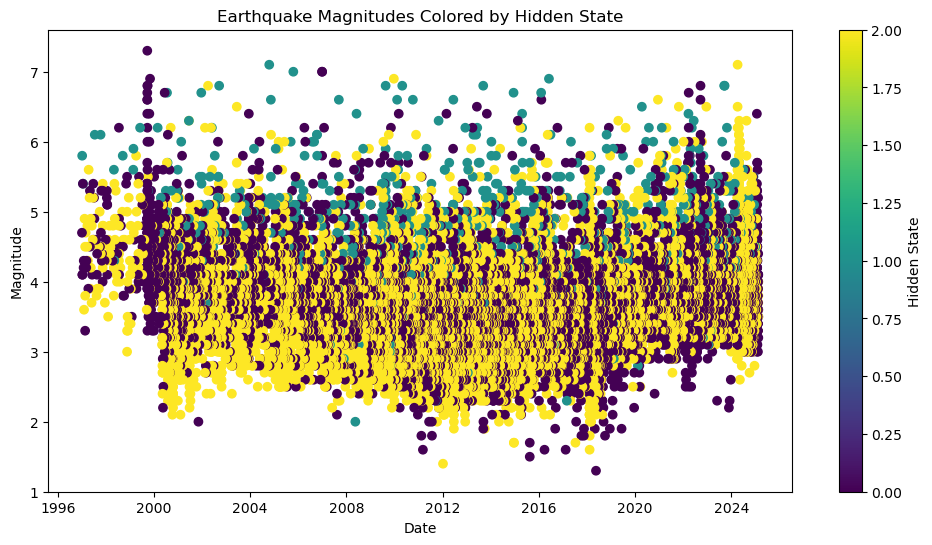

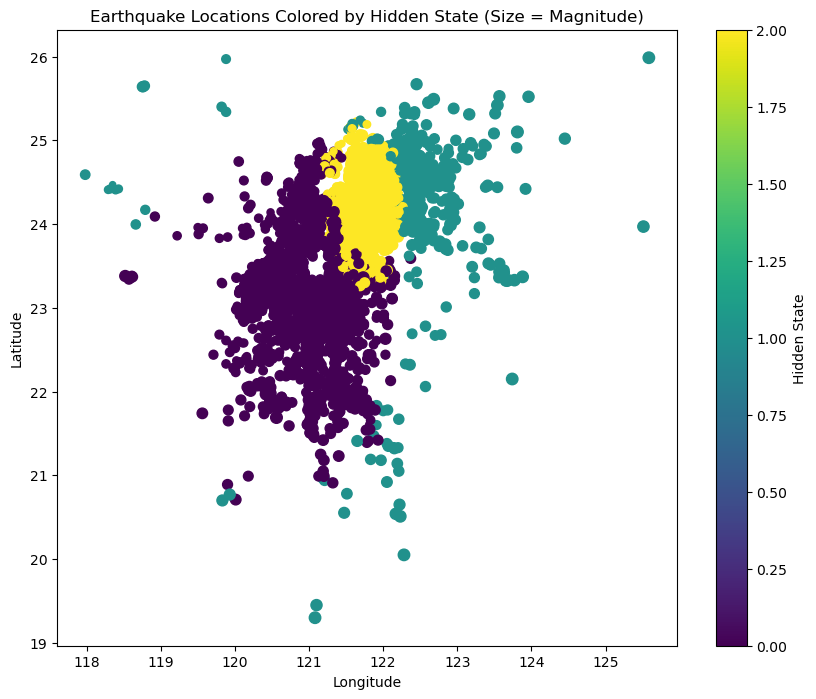

In [44]:
# Plot states over time
plt.figure(figsize=(12, 6))
plt.scatter(df['datetime'], df['Magnitude'], c=df['state'], cmap='viridis')
plt.colorbar(label='Hidden State')
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.title('Earthquake Magnitudes Colored by Hidden State')
plt.show()

# Plot spatial distribution of states
plt.figure(figsize=(10, 8))
plt.scatter(df['Longitude(E)'], df['Latitude(N)'], c=df['state'], cmap='viridis', s=df['Magnitude']*10)
plt.colorbar(label='Hidden State')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Earthquake Locations Colored by Hidden State (Size = Magnitude)')
plt.show()

With the magnitude data and location data
-  Spatial clustering of states reveals zones with distinct seismic behaviors (e.g., fault segments). Larger magnitudes tend to co-occur with specific states.

with the 3 state models, it was:
1. Background activity
2. possibly foreshadowing main shocks
3. main shocks
4. after shocks (clustered)

# Forecasting 5 steps ahead

In [45]:
# Forecast next 5 earthquakes
forecast = predictor.forecast_next(n_steps=5)
print(forecast[['date', 'longitude', 'latitude', 'pred_magnitude', 'pred_depth', 'state']])

                           date   longitude   latitude  pred_magnitude  \
0 2025-02-12 00:09:00.000000000  121.528673  23.751372        2.284790   
1 2020-06-22 23:41:55.866633728  121.996493  24.272866        2.934111   
2 2027-06-07 07:35:37.158931504  121.095188  23.596453        4.468570   
3 2021-01-25 13:30:24.102305792  120.587491  23.337423        3.589823   
4 2030-11-04 12:28:34.488198240  120.816131  23.211795        3.397423   

   pred_depth  state  
0   14.381278      2  
1    9.317367      2  
2    4.294407      0  
3   12.701387      0  
4    4.072824      0  


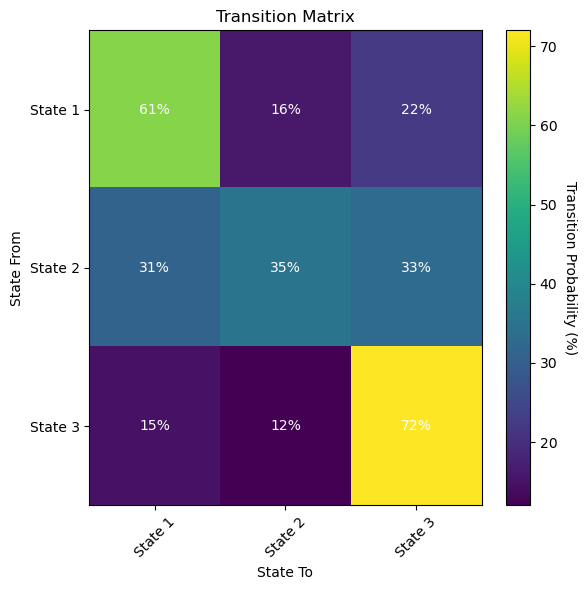

<Figure size 640x480 with 0 Axes>

In [46]:
transmat = predictor.get_transmat()
transmat_int = (transmat * 100).astype(int)

# Create the heatmap
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(transmat_int, aspect='auto', cmap='viridis')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Transition Probability (%)', rotation=-90, va="bottom")
for i in range(transmat_int.shape[0]):
    for j in range(transmat_int.shape[1]):
        ax.text(j, i, f'{transmat_int[i, j]}%', ha='center', va='center', color='white')   
ax.set_title('Transition Matrix')
ax.set_xlabel('State To')
ax.set_ylabel('State From')
ax.set_xticks(np.arange(transmat_int.shape[1]))
ax.set_yticks(np.arange(transmat_int.shape[0]))
ax.set_xticklabels([f'State {i+1}' for i in range(transmat_int.shape[1])])
ax.set_yticklabels([f'State {i+1}' for i in range(transmat_int.shape[0])])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("GaussianHMM_transmat.png")

So, we predict the next sequence of states and use the emission probabilities to predict 

For each state, Gaussian distributions model features like:
- Spatial: longitude, latitude
- Temporal: days_since_last_event (time between consecutive earthquakes)
- Physical: magnitude, depth

Each state encapsulates a unique temporal pattern.
- State 0: Long quiet periods (e.g., tectonic stress buildup).
- State 1: Frequent small quakes (e.g., foreshocks).

Simplification: Using the mean provides a single, interpretable estimate for forecasting.

Alignment with HMM Logic: The model assumes observations (including time intervals) are generated by the current state’s emission distribution.

## Problem

The features that we are using as evidence but then also predicting, have fixed distributions per state so, using it for time would not make much sense. It would make sense to predict the sequence of states and then use the updated probabilities for predicting magnitude, depth, maybe location. 

We might also get stuck in continuous training as it uses Viterbi or forward-backward and in both cases we are using all the data from 0:N to train the model which requires retraining with a new batch of data points and getting new emission probabilities for transition matrices if we want.

# BIC scores (made a mistake, dont mind anything below)

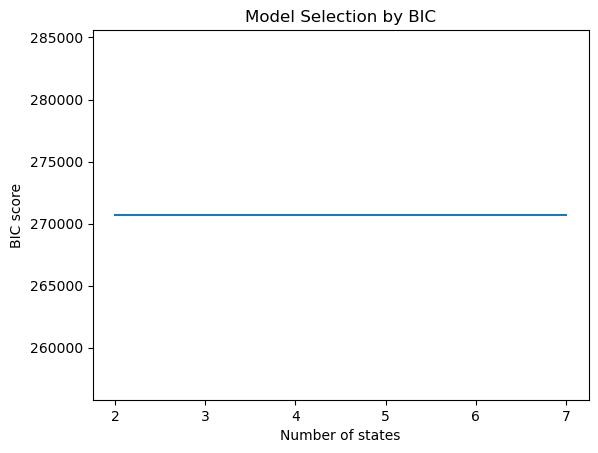

In [47]:
bic_scores = predictor.get_bicscores()
plt.plot(range(2, 8), bic_scores)
plt.xlabel('Number of states')
plt.ylabel('BIC score')
plt.title('Model Selection by BIC')
plt.show()

In [48]:
bic_scores

[np.float64(270702.0720781948),
 np.float64(270702.0720781948),
 np.float64(270702.0720781948),
 np.float64(270702.0720781948),
 np.float64(270702.0720781948),
 np.float64(270702.0720781948)]